# Trabajo práctico Laboratorio de datos

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, f1_score, accuracy_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt
from inline_sql import sql, sql_val
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier

## Análisis de los datos

In [8]:
#Cargamos los datos
#carpeta = "..."
df = pd.read_csv(carpeta+'/fashion-mnist.csv')

### Atributos relevantes

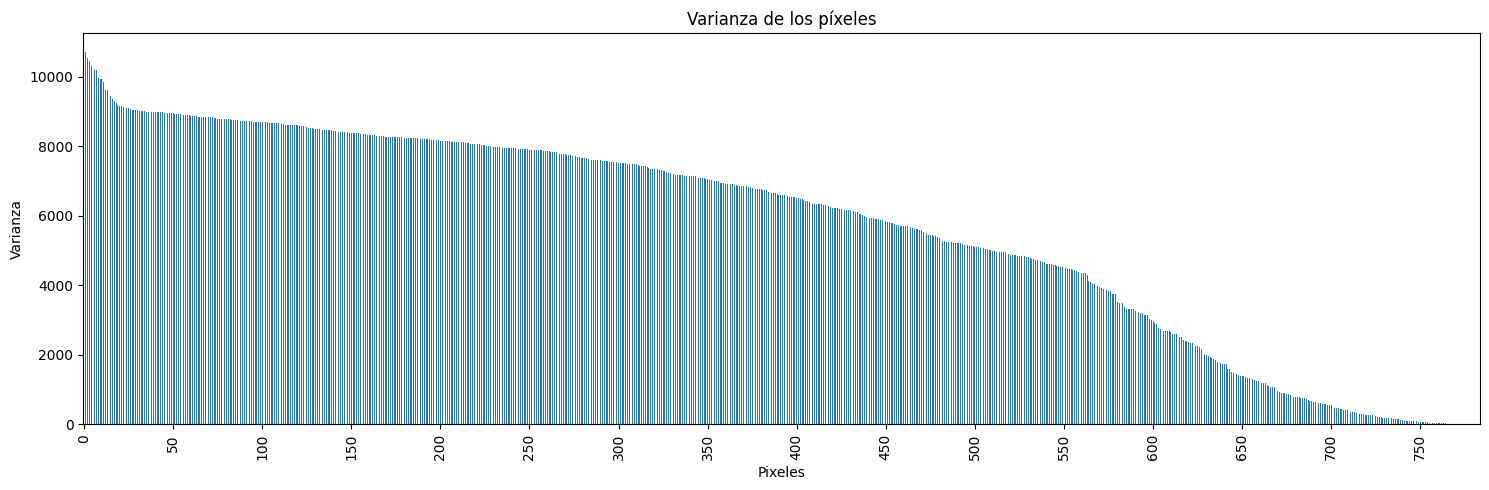

In [ ]:
# Eliminamos la columna 'label' para tener solo los píxeles
pixels = df.drop('label', axis=1)

# Calculamos la varianza de cada píxel
variances = pixels.var()

# Ordenamos las varianzas de mayor a menor
sorted_variances = variances.sort_values(ascending=False)

# Visualización
plt.figure(figsize=(15,5))
sorted_variances.plot(kind='bar')
plt.ylabel('Varianza')
plt.xlabel('Pixeles')
plt.title('Varianza de los píxeles')
# Ajustamos las etiquetas del eje x para que se muestren en intervalos de 50
ticks = list(range(0, len(sorted_variances), 50))
labels = [str(i) for i in ticks]
plt.xticks(ticks, labels, rotation=90)
plt.tight_layout()
plt.show()

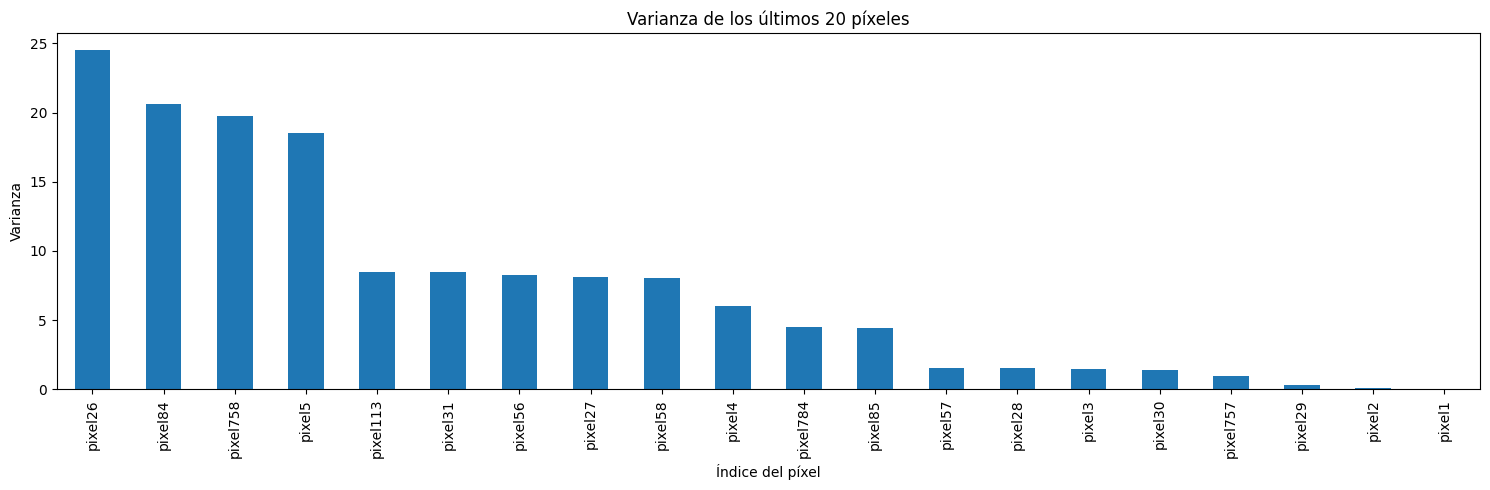

In [ ]:
# Seleccionamos los últimos 20 pixeles
ultimos_pixeles = sorted_variances.tail(20)

# Visualización
plt.figure(figsize=(15,5))
ultimos_pixeles.plot(kind='bar')
plt.ylabel('Varianza')
plt.xlabel('Índice del píxel')
plt.title('Varianza de los últimos 20 píxeles')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Diferenciación de prendas

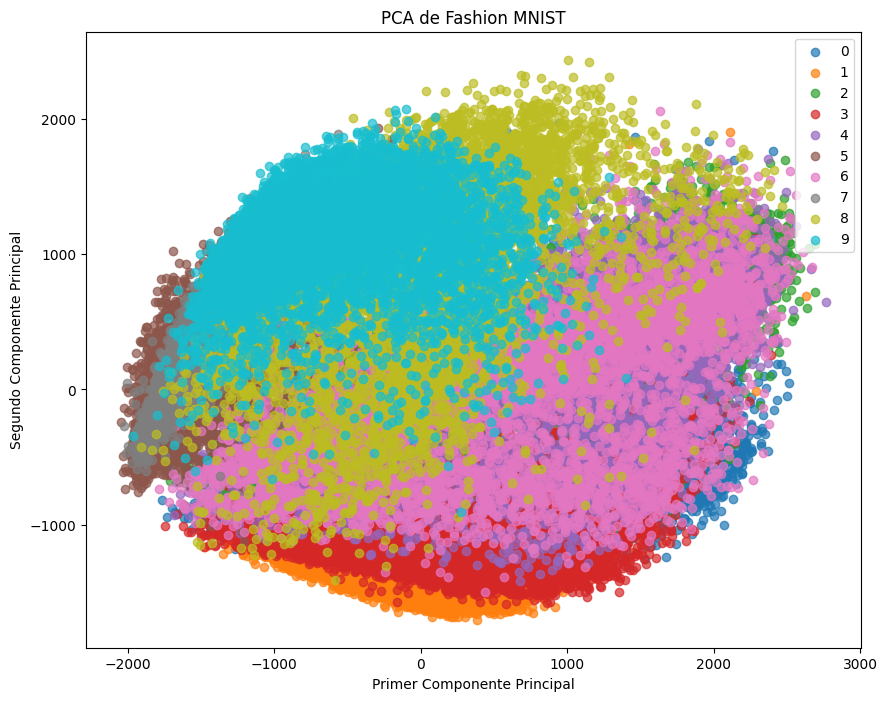

In [ ]:
X = df.drop('label', axis=1)
y = df['label']

#Utilizaremos PCA para diferenciar las prendas
pca = PCA(n_components=2)
matriz_pca = pca.fit_transform(X)

#Graficamos
plt.figure(figsize=(10, 8))
#Asignamos etiquetas
for i in sorted(y.unique()):
    plt.scatter(matriz_pca[y == i, 0], matriz_pca[y == i, 1], label=f'{i}', alpha=0.7)

plt.xlabel('Primer Componente Principal')
plt.ylabel('Segundo Componente Principal')
plt.title('PCA de Fashion MNIST')
plt.legend(loc='upper right')
plt.show()

### Diferenciación de vestidos

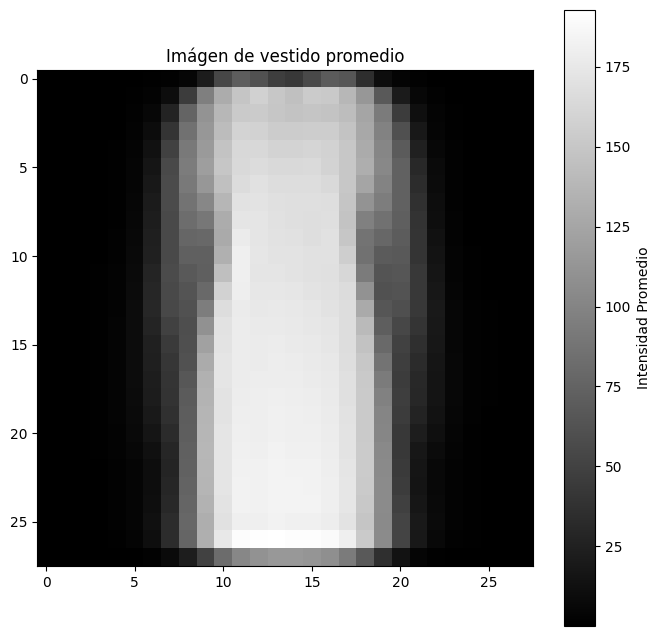

In [ ]:
# Filtramos solo vestidos
vestidos = df[df['label'] == 3].drop('label', axis=1)

# Calculamos la "imagen promedio"
imagen_promedio = vestidos.mean().values.reshape(28, 28)

# Visualización
plt.figure(figsize=(8,8))
plt.imshow(imagen_promedio, cmap='gray')
plt.colorbar(label='Intensidad Promedio')
plt.title('Imágen de vestido promedio')
plt.show()

## Clasificación con Knn

In [4]:
# Creamos un nuevo data frame que contenga solo los datos de las remeras y pantalones
r_y_p = df[(df['label'] == 0) | (df['label'] == 1)]

In [5]:
# Dividimos en test(20%) y train(80%)
train, test = train_test_split(r_y_p, test_size=0.2)

### Balanceo de nuestros datos

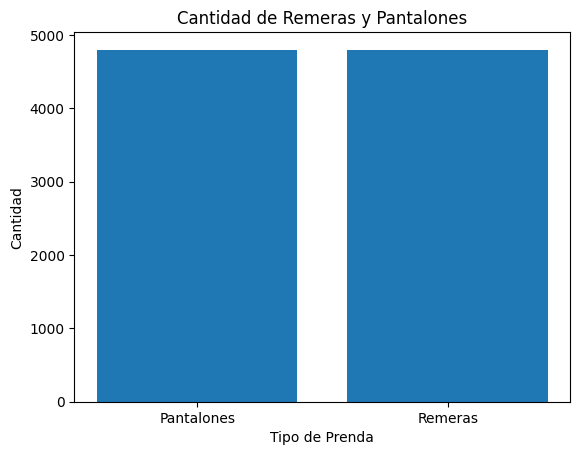

In [ ]:
# Contar la cantidad de remeras y pantalones
conteo = train['label'].value_counts()

# Crear el histograma
plt.bar(conteo.index, conteo.values, tick_label=['Remeras', 'Pantalones'])

# Agregar etiquetas y título
plt.xlabel('Tipo de Prenda')
plt.ylabel('Cantidad')
plt.title('Cantidad de Remeras y Pantalones')

# Mostrar el gráfico
plt.show()

In [ ]:
#Cantidad de remeras y pantalones en nuestro dataset train.
contarpantalones = sql ^ """SELECT count(*) 
                    FROM train
                    where label = 1
                    """
contarremeras = sql  ^"""select count(*) from train where label = 0"""

print("Cantidad de pantalones: ", contarpantalones)
print("Cantidad de remeras: ", contarremeras)

Cantidad de pantalones:     count_star()
0          4785
Cantidad de remeras:     count_star()
0          4815


### Modelado

In [ ]:
#Buscamos los atributos con mayor varianza.
# Calculamos la varianza de cada píxel
pixeles_train = train.drop('label', axis=1)
varianza_pixeles_train = pixeles_train.var()

#calculamos la desviación estandar
desviacion_pixeles = pixeles_train.std()

# Encontrar los índices de los 6 píxeles con mayor varianza
top_6_var_train = varianza_pixeles_train.nlargest(6).index
top_6_desv_train = desviacion_pixeles.sort_values(ascending=False).index

print("Top 6 píxeles con mayor varianza:")
for i in top_6_var_train:
    print(i)

print("Top 6 píxeles con mayor desviación:")
for i in top_6_desv_train[0:6]:
    print(i)  

Top 6 píxeles con mayor varianza:
pixel743
pixel737
pixel738
pixel260
pixel742
pixel748
Top 6 píxeles con mayor desviación:
pixel743
pixel737
pixel738
pixel260
pixel742
pixel748


In [ ]:
#Busqueda de la tripla de pixeles con mejor R^2

mejorTripla = []
mejorTriplaScore = 0
pixels = varianza_pixeles_train.nlargest(784).index
for i in range(len(varianza_pixeles_train)-500):
    Xc = train[[pixels[i],pixels[i+1],pixels[i+2]]]
    yc = train['label']
    predictorChico = KNeighborsClassifier(n_neighbors=5)
    predictorChico.fit(Xc, yc)
    Xtc = test[[pixels[i],pixels[i+1],pixels[i+2]]]
    ytc = test['label']
    predictorChico.score(Xtc, ytc)
    if mejorTriplaScore < r2_score(predictorChico.predict(Xtc), ytc):
        mejorTriplaScore = r2_score(predictorChico.predict(Xtc), ytc)
        mejorTripla = [pixels[i],pixels[i+1],pixels[i+2]]

print("Mejor Tripla: ",mejorTripla)
print("Score: ",mejorTriplaScore)

Mejor Tripla:  ['pixel654', 'pixel715', 'pixel219']
Score:  0.9016649594611017


In [6]:
#Ajustamos un modelo de KNN considerando la mejor tripla que obtuvimos en la celda anterior.

# declaramos variables
Xc = train[['pixel654','pixel715','pixel219']]
yc = train['label']

## declaramos variables para el test
Xtc = test[['pixel654','pixel715','pixel219']]
ytc = test['label']

# generamos un modelo y lo entrenamos
predictorChico = KNeighborsClassifier(n_neighbors=5)
predictorChico.fit(Xc, yc)

#Calculamos su R2:
print("Accuracy (train): %.2f" % predictorChico.score(Xtc, ytc))

Accuracy (train): 0.960


In [ ]:
#Ajustamos un modelo de KNN considerando los tres atributos con mayor varianaza.

# declaramos variables
Xc = train[['pixel738','pixel737','pixel743']]
yc = train['label']

## declaramos variables para el test
Xtc = test[['pixel738','pixel737','pixel743']]
ytc = test['label']

# generamos un modelo y lo entrenamos
predictorChico = KNeighborsClassifier(n_neighbors=5)
predictorChico.fit(Xc, yc)

#Calculamos su R2:
print("Accuracy (train): %.2f" % predictorChico.score(Xtc, ytc))

Accuracy (train): 0.96


In [ ]:
#Ajustamos un modelo de KNN considerando todos los atributos(pixeles)

# declaramos variables
Xs = train.drop('label', axis=1)
ys = train['label']

## declaramos variables para el test
Xt = test.drop('label', axis=1)
yt = test['label']

# generamos un modelo y lo entrenamos
predictor = KNeighborsClassifier(n_neighbors=3)

predictor.fit(Xs, ys)

#Calculamos su R2:
print("Accuracy (test): %.2f" % predictor.score(Xt, yt))


Accuracy (test): 0.99


### Comparación de modelos KNN

In [ ]:
#este tarda 30 minutos aprox
resultados_test  = np.zeros((len(valores_k),len(valores_k)))
#repetimos el experimento 100 veces y sacamos el promedio
for i in range(100):
    print(i)
    train, test = train_test_split(r_y_p, test_size=0.2)

    # Rango de valores por los que se va a mover k
    valores_k = range(1, 10)
    #pxm = pixeles mas usados
    pxm = varianza_pixeles_train.sort_values(ascending=False).index[0:10]

    ys = train['label']
    yt = test['label']

    Xs = train[pxm]
    Xt = test[pxm]

    for k in range(1,10):
        for p in range(9):
            # Declaramos el tipo de modelo
            neigh = KNeighborsClassifier(n_neighbors = k)
            # Entrenamos el modelo (con datos de train)
            neigh.fit(Xs, ys)
            # Evaluamos el modelo con datos de train y luego de test
            resultados_test[k-1][p]  += neigh.score(Xt , yt)
            Xs = train[pxm[p+1:]]
            Xt = test[pxm[p+1:]]
resultados_test = resultados_test/30

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
resultados_test = resultados_test*30/100

([<matplotlib.axis.XTick at 0x7efb71226670>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

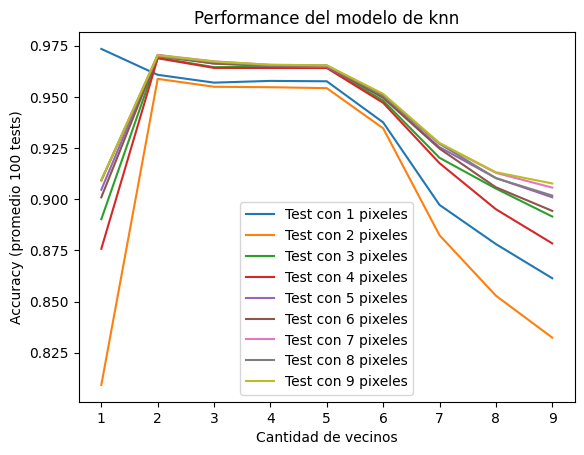

In [ ]:
for i in range(len(resultados_train)):
    plt.plot(valores_k, resultados_test[i], label = f'Test con {i+1} pixeles')
plt.legend()
plt.title('Performance del modelo de knn')
plt.xlabel('Cantidad de vecinos')
plt.ylabel('Accuracy (promedio 100 tests)')
plt.xticks(valores_k)

## Clasificación multiclase - Árbol de decision

In [ ]:
# Declaramos las variables
X = df.drop('label', axis=1)
y = df['label']

# Separamos en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

### Comparación de modelos con distintos parámetros

In [ ]:
#Vamos a ver cuál es la mejor profundidad para nuestro árbol de decisión

# Vamos a buscar el rango de valores que queremos explorar para nuestros hyperparametros.

# Declaramos el tipo de modelo
arbol = DecisionTreeClassifier()

# Entrenamos el modelo
search = arbol.fit(X_train, y_train)

#Imprimimos la altura máxima
print("Altura max: ", arbol.get_depth())

Altura max:  45


In [ ]:
#Comparamos distintas alturas en nuestro rango y criterios entre entropia y gini 
hyper_params =  {'criterion': ['entropy', 'gini'],
                 'max_depth' : [*range(1,45)]}

#Hacemos random_search
clf = RandomizedSearchCV(arbol, hyper_params, random_state=0)
search = clf.fit(X_train, y_train)
#Buscamos los mejores parametros para nuestro modelo
print(search.best_params_)

{'max_depth': 14, 'criterion': 'entropy'}


### K-folding

In [ ]:
#Declaramos nuestro arbol con los hiperparámetros que obtuvimos en el punto anterior
arbol_model = DecisionTreeClassifier(criterion='entropy', max_depth=14, random_state=0)

#Evaluamos el modelo utilizando validacion cruzada con k-folding utilizando 5 folds
cross_val_score(arbol_model, X_train, y_train, cv=5)

array([0.81208333, 0.8009375 , 0.80708333, 0.8084375 , 0.809375  ])

In [ ]:
#Entrenamos el modelo con los datos de train
arbol_model.fit(X_train,y_train)

# Realizamos predicciones en el conjunto de prueba
y_pred = arbol_model.predict(X_test)

# Evaluamos la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy:.2f}')

Precisión del modelo: 0.81


In [ ]:
#Imprimimos todas las medidas de performance de nuestro modelo
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.77      0.75      1150
           1       0.96      0.94      0.95      1191
           2       0.71      0.68      0.69      1249
           3       0.82      0.83      0.82      1217
           4       0.67      0.74      0.71      1144
           5       0.91      0.87      0.89      1215
           6       0.59      0.53      0.56      1224
           7       0.85      0.90      0.87      1144
           8       0.92      0.94      0.93      1217
           9       0.91      0.89      0.90      1249

    accuracy                           0.81     12000
   macro avg       0.81      0.81      0.81     12000
weighted avg       0.81      0.81      0.81     12000



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5a49b936-a87d-4f29-8983-1bd8e562bcd4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>